![Alt text](images/banner.png)

## Training Notebook 

### Initial Setup

Some initial setup specific to running this notebook as part of the pipeline.

In [ ]:
import os
#This environment variable is automatically set in WS Pipelines and are needed to access various services.
TOKEN = os.getenv("USER_ACCESS_TOKEN")

In [ ]:
if os.getenv("running_in_production_pipeline"):
    running_in_production_pipeline = True
    # If you want to run additional steps when deploying to production like reporting to external services, you can use this variable to trigger that
    # It can also be used to skip steps that are only needed in development like plotting
    print("notebook is running in a production pipeline!")
else:
    running_in_production_pipeline = False
    print("notebook is running in a development enviroment!")

## Imports

In [3]:
from botocore.client import Config
from ibm_botocore.client import Config
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score,auc,roc_curve,accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from ibm_watson_studio_pipelines import WSPipelines
from ibm_watson_machine_learning import APIClient
import warnings
import os
import pandas as pd
import numpy as np
import ibm_boto3
import json
import pickle
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from os.path import exists

warnings.filterwarnings("ignore")

try:
    import seaborn  as sns
except Exception as e:
    print(str(e) + " - Optional pluging skipped")
    
# Loading Variables and Utils from common python file
import vars_and_utils as vars_and_utils
    
# some variables are stored in a .env file. Refer to readme for more information
load_dotenv()
project_id= os.getenv('PROJECT_ID')

## Utility Functions

## Load the Saved Transformer from IBM COS 

In [ ]:
vars_and_utils.pipeline_path

In [6]:
pipeline = vars_and_utils.load_model(vars_and_utils.pipeline_path)

## Instantiate FactSheets Client

In [7]:
# removing temporarly due to installation issues

# # Set-up Factsheets
# cpd_creds = CloudPakforDataConfig(service_url=CPD_HOST, username=CPD_USERNAME, password=CPD_PASSWORD)
    
# if SPACE_ID is None:
#     # Only of SPACE_ID is unavailble, fallback to PROJECT_ID
#     if PROJECT_ID is None:
#         # Neither SPACE_ID nor PROJECT_ID available
#         pass
#     else:
#         # PROJECT_ID available
#         deploy_to = 'project'
#         try:
#             # Create new experiment
#             facts_client = AIGovFactsClient(experiment_name=EXPERIMENT_NAME,container_type=deploy_to,container_id=PROJECT_ID,cloud_pak_for_data_configs=cpd_creds)
#         except Exception as e:
#             # Experiment already exists.. set as current experiment
#             facts_client = AIGovFactsClient(experiment_name=EXPERIMENT_NAME,container_type=deploy_to,container_id=PROJECT_ID,cloud_pak_for_data_configs=cpd_creds,set_as_current_experiment=True)
#         else:
#             print(e)
# else:
#     # SPACE_ID is available
#     deploy_to = 'space'
#     try:
#         # Create new experiment
#         facts_client = AIGovFactsClient(experiment_name=EXPERIMENT_NAME,container_type=deploy_to,container_id=SPACE_ID,cloud_pak_for_data_configs=cpd_creds)
#     except Exception as e:
#         # Experiment already exists.. set as current experiment
#         facts_client = AIGovFactsClient(experiment_name=EXPERIMENT_NAME,container_type=deploy_to,container_id=SPACE_ID,cloud_pak_for_data_configs=cpd_creds,set_as_current_experiment=True)
#     else:
#         print(e)
        
# print(f"Setting up Factsheets in {deploy_to}")

## Load Train Data and Test Data 

In [8]:
train_data = pd.read_csv(vars_and_utils.train_data_path)
test_data = pd.read_csv(vars_and_utils.test_data_path)
train_data.head()

,LoanDuration,LoanAmount,InstallmentPercent,CurrentResidenceDuration,Age,ExistingCreditsCount,Dependents,CheckingStatus,ExistingSavings,Telephone,OthersOnLoan,OwnsProperty,Housing,Job,LoanPurpose,EmploymentDuration,CreditHistory,Sex,Risk
0,18,462,2,2,37,2,1,less_0,less_100,none,none,savings_insurance,own,skilled,car_new,1_to_4,credits_paid_to_date,female,0
1,15,250,2,3,28,2,1,less_0,less_100,yes,none,real_estate,own,skilled,furniture,1_to_4,prior_payments_delayed,male,0
2,28,6235,3,3,57,2,1,no_checking,500_to_1000,none,none,unknown,own,skilled,education,greater_7,prior_payments_delayed,male,1
3,9,1032,3,4,41,1,1,no_checking,100_to_500,none,none,savings_insurance,own,management_self-employed,car_new,4_to_7,prior_payments_delayed,male,0
4,11,4553,3,3,22,1,1,0_to_200,less_100,none,none,savings_insurance,own,management_self-employed,car_new,less_1,credits_paid_to_date,female,0


## Load train and test set

In [9]:
y_train = train_data['Risk']

y_test = test_data['Risk']

X_train = train_data.drop('Risk',axis=1)

X_test = test_data.drop('Risk',axis=1)

## Make validation set

In [10]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

## Instantiate a Classifier 

In [11]:
from lightgbm import LGBMClassifier

model_lgb = LGBMClassifier(learning_rate=0.1,max_depth=5,random_state=42)

## Append the Pipeline

In [12]:
estimator_step = ['model_lgb',model_lgb]
pipeline.steps.append(estimator_step)

In [13]:
pipeline.steps[0][1].fit(X_tr)

ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                 Index(['CheckingStatus', 'ExistingSavings', 'Telephone', 'OthersOnLoan',
       'OwnsProperty', 'Housing', 'Job', 'LoanPurpose', 'EmploymentDuration',
       'CreditHistory', 'Sex'],
      dtype='object')),
                                ('num', MinMaxScaler(),
                                 Index(['LoanDuration', 'LoanAmount', 'InstallmentPercent',
       'CurrentResidenceDuration', 'Age', 'ExistingCreditsCount',
       'Dependents'],
      dtype='object'))])

## Baseline Model 

In [14]:
print("starting Model Training. This might take a while")
model_pipeline = pipeline.fit(X_tr,y_tr,model_lgb__verbose=5, model_lgb__eval_set=[(pipeline.steps[0][1].transform(X_val), y_val),(pipeline.steps[0][1].transform(X_tr), y_tr)])

starting Model Training. This might take a while
[5]	valid_0's binary_logloss: 0.539933	valid_1's binary_logloss: 0.516468
[10]	valid_0's binary_logloss: 0.495028	valid_1's binary_logloss: 0.45781
[15]	valid_0's binary_logloss: 0.47201	valid_1's binary_logloss: 0.422009
[20]	valid_0's binary_logloss: 0.460184	valid_1's binary_logloss: 0.397386
[25]	valid_0's binary_logloss: 0.452409	valid_1's binary_logloss: 0.379933
[30]	valid_0's binary_logloss: 0.447527	valid_1's binary_logloss: 0.366433
[35]	valid_0's binary_logloss: 0.444819	valid_1's binary_logloss: 0.356152
[40]	valid_0's binary_logloss: 0.441855	valid_1's binary_logloss: 0.347831
[45]	valid_0's binary_logloss: 0.440161	valid_1's binary_logloss: 0.34118
[50]	valid_0's binary_logloss: 0.437747	valid_1's binary_logloss: 0.335239
[55]	valid_0's binary_logloss: 0.436925	valid_1's binary_logloss: 0.328646
[60]	valid_0's binary_logloss: 0.437222	valid_1's binary_logloss: 0.322972
[65]	valid_0's binary_logloss: 0.437369	valid_1's binar

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

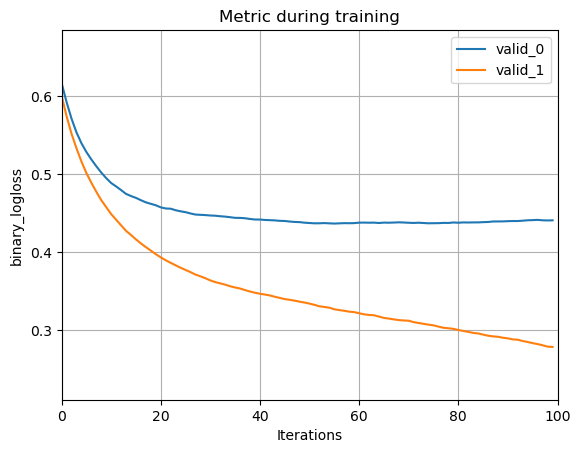

In [15]:
from lightgbm import plot_metric
plot_metric(pipeline.steps[1][1])

## Log the Train and Val loss

In [ ]:
val_loss = pipeline.steps[1][1].evals_result_['valid_0']
train_loss = pipeline.steps[1][1].evals_result_['valid_1']

## Save train and val loss to COS

In [ ]:
val_loss_path = os.path.join(vars_and_utils.data_path, 'val_loss.pkl')
vars_and_utils.save_data_in_filesystem(val_loss, val_loss_path)

train_loss_path = os.path.join(vars_and_utils.data_path, 'train_loss.pkl')
vars_and_utils.save_data_in_filesystem(train_loss, train_loss_path)

## Check if the files are copied in COS


In [ ]:
files_copied_in_cos = os.path.exists(val_loss_path) and os.path.exists(train_loss_path)
files_copied_in_cos

## Baseline Results of the Model

In [ ]:
predictions = pipeline.predict(X_test)

print(roc_auc_score(y_test,predictions))

In [ ]:
if not running_in_production_pipeline:
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.mean(cross_val_score(pipeline,X_train,y_train, cv=cv, n_jobs=-1,scoring='roc_auc'))
    print(f"The Cross Validated AUC_ROC Score is {scores}")
else:
    print("Skipping KFold Validation in the production pipeline")

In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(pipeline.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(pipeline.score(X_test, y_test)))

In [ ]:
df_cm = confusion_matrix(y_test,predictions)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in df_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in df_cm.flatten()/np.sum(df_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2,v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

try:
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')
except Exception as e:
    print(str(e) + " - Seaborn missing, skipping optional heatmap plot.")

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print("\n")
print ("Area Under Curve: %.2f" %auc(fpr, tpr))
print("\n")

## Serialize Model locally

In [ ]:
with open(vars_and_utils.model_path,'wb') as f:
    pickle.dump(model_pipeline,f)

In [ ]:
# skipping for now due to installation issues
# cpd_ver = facts_client.get_cpd_version()[:3]

In [ ]:
WML_CREDENTIALS = {
   "token": TOKEN,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "4.6"
}

In [ ]:
wml_client = APIClient(WML_CREDENTIALS)

## Save and Log Models in AI Factsheets.

In [ ]:
# TODO: Rework this without helper scripts

## Custom succes check: Check if training and test score are above a (very low) threshold

In [ ]:
training_score=pipeline.score(X_train, y_train)
test_score=pipeline.score(X_test, y_test)


if (training_score>0.7) & (test_score>0.6) & os.path.exists(vars_and_utils.model_path):
    training_successful=True
else:
    training_successful=False

training_successful


## Register the output variables for the next pipeine stage
every notebook outputs a "was_successful" boolean variable. The logic behind this is different for every notebook and can be altered to fit the needs of the project.
If needed additional variables can be created here but they also need to registered as output variables in the Watson Pipelines UI.

In [ ]:
train_params = {}
train_params['was_succesfull'] = training_successful


pipelines_client = WSPipelines.from_token(TOKEN)
pipelines_client.store_results(train_params)